In [1]:
# %pip install gdown

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import numpy as np
from tqdm.notebook import tqdm
from dataclasses import dataclass



libgomp: Invalid value for environment variable OMP_NUM_THREADS


In [6]:
device = 'cuda:0'

@dataclass
class config:
    # data params
    batch_size = 64
    # optim params
    lr = 1e-3
    weight_decay = 0
    n_gradient_accumulation_steps = 1
    max_grad_norm = 1.0
    # logging
    log_every_n_grad_steps = 512

# Load data

In [7]:
# # Donwload the sample dataset 

# import gdown
# url = 'https://drive.google.com/file/d/1-RQzMIX4yzOYcHRnc-5K6B98eR2dypz6/view?usp=sharing'
# output = 'data/'
# gdown.download(url, output, quiet=False, fuzzy=True)

In [8]:
import safetensors
import pathlib
import os 
import matplotlib.pyplot as plt

path_data = pathlib.Path("data/clf_features_20_50.safetensors")
data = safetensors.safe_open(path_data, framework='pt')
X, y = data.get_tensor('x_50'), data.get_tensor('y')
print(X.shape, y.shape)
print(f'Unique vals in y: {y.unique()}')

torch.Size([1272821, 512]) torch.Size([1272821])
Unique vals in y: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28], dtype=torch.uint8)


In [9]:
test_ratio = 0.01
split_id_train = int(len(X) * (1-test_ratio))

X_train, X_eval = X[:split_id_train], X[split_id_train:]
y_train, y_eval = y[:split_id_train], y[split_id_train:]

train_loader = DataLoader(
    dataset=X_train,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=False,
    drop_last=True
)
eval_loader = DataLoader(
    dataset=X_eval, 
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True
)

# What the '0' is for - the one that is dropped in the LESS paper when acquiring 2D maps

[ 0  1  3  8 10 11 12 14 15 16 17 24]


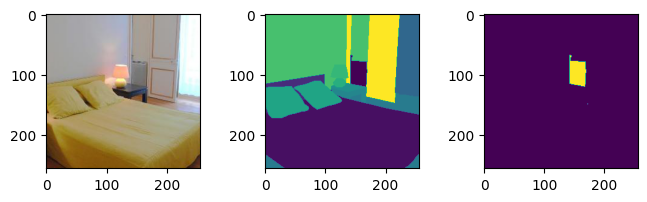

[ 0  1  2  3  8  9 10 14 17 18]


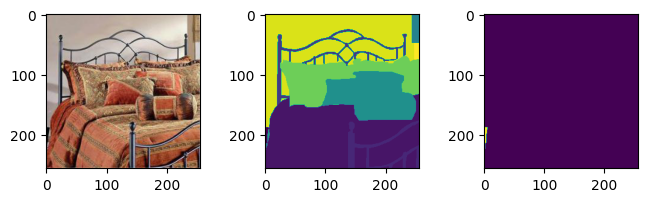

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 22 25]


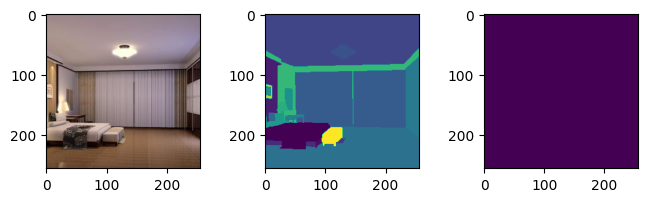

[ 0  1  3  9 10 11 12 13 14 15 16 17 22]


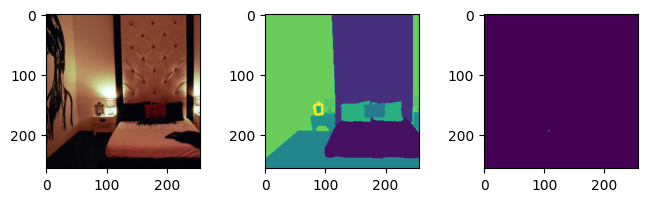

In [10]:
files_img_dataset = 'diffusion-dict-learn/datasets/bedroom_28/real/test'
uniques_filename = list(set([name_.split('.')[0] for name_ in os.listdir(files_img_dataset)]))

num_iter = 4
for filename in uniques_filename[15:15+num_iter]:
    file_mask = pathlib.Path(files_img_dataset) / f"{filename}.npy"
    img_mask = np.load(file_mask)    
    file_png = pathlib.Path(files_img_dataset) / f"{filename}.png"
    img_png = plt.imread(file_png)

    # Unique classes on the mask
    print(np.unique(img_mask))

    f, axs = plt.subplots(1,3, figsize=(8,2))
    axs[0].imshow(img_png)
    axs[1].imshow(img_mask)
    axs[2].imshow(img_mask==0)
    # plt.axes(False)
    plt.show()

> 0 label seems to be reserved for others

# SAE training

Starting with more vanilla SAE w/o top-k or JumpRelu

> Taken from https://github.com/ApolloResearch/e2e_sae/blob/main/e2e_sae/models/sparsifiers.py

In [11]:
import torch
import torch.nn.functional as F
from torch import nn

class SAE(nn.Module):
    """
    Sparse AutoEncoder
    """

    def __init__(
        self, input_size: int, n_dict_components: int, init_decoder_orthogonal: bool = True
    ):
        """Initialize the SAE.

        Args:
            input_size: Dimensionality of input data
            n_dict_components: Number of dictionary components
            init_decoder_orthogonal: Initialize the decoder weights to be orthonormal
        """

        super().__init__()
        # self.encoder[0].weight has shape: (n_dict_components, input_size)
        # self.decoder.weight has shape:    (input_size, n_dict_components)

        self.encoder = nn.Sequential(nn.Linear(input_size, n_dict_components, bias=True), nn.ReLU())
        self.decoder = nn.Linear(n_dict_components, input_size, bias=True)
        self.n_dict_components = n_dict_components
        self.input_size = input_size

        if init_decoder_orthogonal:
            # Initialize so that there are n_dict_components orthonormal vectors
            self.decoder.weight.data = nn.init.orthogonal_(self.decoder.weight.data.T).T

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """Pass input through the encoder and normalized decoder."""
        h = self.encoder(x)
        x_hat = F.linear(h, self.dict_elements, bias=self.decoder.bias)
        return x_hat, h

    @property
    def dict_elements(self):
        """Dictionary elements are simply the normalized decoder weights."""
        return F.normalize(self.decoder.weight, dim=0)

    @property
    def device(self):
        return next(self.parameters()).device

## Loss

In [12]:
class SparsityLoss():
    def __init__(self):
        self.p_norm: float = 1.0

    def calc_loss(self, h, dense_dim: int):
        """Calculate the sparsity loss.
        Note that we divide by the dimension of the input to the SAE. This helps with using the same
        hyperparameters across different model sizes (input dimension is more relevant than the c
        dimension for Lp loss).
        Args:
            h: The activations after the non-linearity in the SAE.
            dense_dim: The dimension of the input to the SAE. Used to normalize the loss.
        Returns:
            The L_p norm of the activations.
        """
        return torch.norm(h, p=self.p_norm, dim=-1).mean() / dense_dim
    
class ReconstructionLoss():
    def __init__(self):
        pass
    
    def calc_loss(
        self, z, z_hat
    ):
        """Calculate the MSE between the input and orig."""
        return F.mse_loss(z, z_hat)
    
class SAELoss():
    def __init__(self, coef_sparse):
        self.rec_loss = ReconstructionLoss()
        self.sparse_loss = SparsityLoss()
        self.coef_sparse = coef_sparse
        
    def calc_loss(
        self, z, z_hat, h
    ):
        """
        Calculate the loss (Sparsity+Reconstr*corf).
            Sparsity on `h`
            Reconstruction b/w z and z_hat
        """
        dense_dim = z.size(-1)
        
        loss_rec = self.rec_loss.calc_loss(z, z_hat)
        loss_sparse = self.sparse_loss.calc_loss(h, dense_dim=dense_dim)
        loss_val = loss_rec + self.coef_sparse*loss_sparse
        
        dict_loss_info = {'rec': loss_rec.detach().cpu().item(), 'sparse': loss_sparse.detach().cpu().item(), 'coef_sparse': self.coef_sparse}
        return loss_val, dict_loss_info

### Train loop

In [17]:
n_batches = len(train_loader)
dense_dim = 512

sae_loss = SAELoss(coef_sparse=0.001)
model = SAE(input_size=dense_dim, n_dict_components=dense_dim*30).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
scheduler = None

# logging 
dict_logs = {}

total_samples = 0
grad_updates = 0
# samples_since_act_frequency_collection = 0
for batch_idx, batch in tqdm(enumerate(train_loader), total=n_batches, desc="Steps"):
    # dense_embs [bs, dense_dim]
    # dense_dim = 512 in LESS paper
    dense_embs, y = batch[0].to(device=device), batch[1]

    total_samples = total_samples + dense_embs.shape[0]
    # samples_since_act_frequency_collection += dense_embs.shape[0]

    is_grad_step: bool = (batch_idx + 1) % config.n_gradient_accumulation_steps == 0
    
    # # Note that is_last_batch will always be False for iterable datasets with n_samples=None. In
    # # that case, we will never know when the final batch is reached.
    # is_last_batch: bool = n_batches is not None and batch_idx == n_batches - 1
    # is_eval_step: bool = config.eval_every_n_samples is not None and (
    #     (batch_idx == 0)
    #     or total_samples - total_samples_at_last_eval >= config.eval_every_n_samples
    #     or is_last_batch
    # )
    # is_collect_act_frequency_step: bool = config.collect_act_frequency_every_n_samples > 0 and (
    #     batch_idx == 0
    #     or (
    #         samples_since_act_frequency_collection
    #         >= config.collect_act_frequency_every_n_samples
    #     )
    # )
    is_log_step: bool = (
        batch_idx == 0
        or (is_grad_step and (grad_updates + 1) % config.log_every_n_grad_steps == 0)
        # or is_eval_step
        # or is_last_batch
    )
    # is_save_model_step: bool = save_dir is not None and (
    #     (
    #         config.save_every_n_samples
    #         and total_samples - total_samples_at_last_save >= config.save_every_n_samples
    #     )
    #     or is_last_batch
    # )

    x_hat, h = model(dense_embs)
    
    loss, dict_loss_info = sae_loss.calc_loss(dense_embs, x_hat, h)

    loss = loss / config.n_gradient_accumulation_steps
    loss.backward()

    if is_grad_step:
        if config.max_grad_norm is not None:
            grad_norm = torch.nn.utils.clip_grad_norm_(
                model.parameters(), config.max_grad_norm
            ).item()
        optimizer.step()
        optimizer.zero_grad()
        grad_updates += 1
        if scheduler is not None:
            scheduler.step()

#     if is_collect_act_frequency_step and act_frequency_metrics is None:
#         # Start collecting activation frequency metrics for next config.act_frequency_n_tokens
#         act_frequency_metrics = ActFrequencyMetrics(
#             dict_sizes={
#                 hook_pos: new_act_pos.c.shape[-1]
#                 for hook_pos, new_act_pos in new_acts.items()
#                 if isinstance(new_act_pos, SAEActs)
#             },
#             device=device,
#         )
#         samples_since_act_frequency_collection = 0

#     if act_frequency_metrics is not None:
#         act_frequency_metrics.update_dict_el_frequencies(
#             new_acts, batch_tokens=tokens.shape[0] * tokens.shape[1]
#         )
#         if act_frequency_metrics.tokens_used >= config.act_frequency_n_tokens:
#             # Finished collecting activation frequency metrics
#             metrics = act_frequency_metrics.collect_for_logging(
#                 log_wandb_histogram=config.wandb_project is not None
#             )
#             metrics["total_tokens"] = total_tokens
#             if config.wandb_project:
#                 # TODO: Log when not using wandb too
#                 wandb.log(metrics, step=total_samples)
#             act_frequency_metrics = None
#             samples_since_act_frequency_collection = 0

    if is_log_step:
        tqdm.write(
            f"Samples {total_samples:08d} Batch_idx {batch_idx:06d} GradUpdates {grad_updates:06d} "
            f"MSE:{dict_loss_info['rec']/config.n_gradient_accumulation_steps:.5f}, "
            f"Sparsity:{dict_loss_info['sparse']*dict_loss_info['coef_sparse']/config.n_gradient_accumulation_steps:.5f}"
        )
        
        for k, v in dict_loss_info.items():
            if k not in dict_logs:
                dict_logs[k] = []
            dict_logs[k].append(v)
#         if config.wandb_project:
#             log_info = {
#                 "loss": loss.item(),
#                 "grad_updates": grad_updates,
#                 "total_tokens": total_tokens,
#                 "lr": optimizer.param_groups[0]["lr"],
#             }
#             log_info.update({k: v.item() for k, v in loss_dict.items()})
#             if grad_norm is not None:
#                 log_info["grad_norm"] = grad_norm  # Norm of grad before clipping

#             sparsity_metrics = calc_sparsity_metrics(new_acts=new_acts)
#             log_info.update(sparsity_metrics)

#             if new_logits is not None:
#                 train_output_metrics = calc_output_metrics(
#                     tokens=tokens,
#                     orig_logits=orig_logits.detach().clone(),
#                     new_logits=new_logits.detach().clone(),
#                 )
#                 log_info.update(train_output_metrics)

#             if is_eval_step:
#                 eval_metrics = evaluate(
#                     config=config, model=model, device=device, cache_positions=cache_positions
#                 )
#                 total_samples_at_last_eval = total_samples
#                 log_info.update(eval_metrics)

#             wandb.log(log_info, step=total_samples)

#     if is_save_model_step:
#         assert save_dir is not None
#         total_samples_at_last_save = total_samples
#         save_module(
#             config_dict=config.model_dump(mode="json"),
#             save_dir=save_dir,
#             module=model.saes,
#             model_filename=f"samples_{total_samples}.pt",
#             config_filename="final_config.yaml",
#         )
#         if config.wandb_project:
#             wandb.save(
#                 str(save_dir / f"samples_{total_samples}.pt"), policy="now", base_path=save_dir
#             )

    # if is_last_batch:
    #     break

Steps:   0%|          | 0/19688 [00:00<?, ?it/s]

Samples 00000512 Batch_idx 000000 GradUpdates 000001 MSE:100.05543, Sparsity:0.02721
Samples 00262144 Batch_idx 000511 GradUpdates 000512 MSE:68.26263, Sparsity:0.00321
Samples 00524288 Batch_idx 001023 GradUpdates 001024 MSE:286.41016, Sparsity:0.00955
Samples 00786432 Batch_idx 001535 GradUpdates 001536 MSE:17.17891, Sparsity:0.00130
Samples 01048576 Batch_idx 002047 GradUpdates 002048 MSE:5.61431, Sparsity:0.00048
Samples 01310720 Batch_idx 002559 GradUpdates 002560 MSE:12.09064, Sparsity:0.00135
Samples 01572864 Batch_idx 003071 GradUpdates 003072 MSE:128.47751, Sparsity:0.01497
Samples 01835008 Batch_idx 003583 GradUpdates 003584 MSE:12.34322, Sparsity:0.00043
Samples 02097152 Batch_idx 004095 GradUpdates 004096 MSE:6.92811, Sparsity:0.00081
Samples 02359296 Batch_idx 004607 GradUpdates 004608 MSE:14.60176, Sparsity:0.00129
Samples 02621440 Batch_idx 005119 GradUpdates 005120 MSE:7.49796, Sparsity:0.00061
Samples 02883584 Batch_idx 005631 GradUpdates 005632 MSE:768.61908, Sparsity